In [1]:
import os
import cv2
import numpy as np
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.optimizers import Adam

In [2]:
# load the data
train_data = np.load('train_data.npz')
test_data = np.load('test_data.npz')

train_images = train_data['images']
train_labels = train_data['labels']
test_images = test_data['images']
test_labels = test_data['labels']

In [3]:
# data augmentation
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

datagen.fit(train_images)


In [4]:
# preprocess the data
# Normalize the images
train_images = train_images / 255.0
test_images = test_images / 255.0

# Encode labels to numeric values
label_encoder = LabelEncoder()
train_labels = label_encoder.fit_transform(train_labels)
test_labels = label_encoder.fit_transform(test_labels)

In [5]:
# build the neural network
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(100, 100, 3),
                  kernel_regularizer=regularizers.l2(0.001)),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(64, (3, 3), activation='relu', 
                  kernel_regularizer=regularizers.l2(0.001)),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(128, (3, 3), activation='relu', 
                  kernel_regularizer=regularizers.l2(0.001)),
    layers.MaxPooling2D((2, 2)),
    
    layers.Flatten(),
    layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.5),
    layers.Dense(10, activation='softmax')  # 10 classes for 10 fruits
])

model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [6]:
# training

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.001)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

batch_size = 16
history = model.fit(
    datagen.flow(train_images, train_labels, batch_size=batch_size),  # Generates augmented images
    epochs=50,  # Number of training epochs
    validation_data=(test_images, test_labels),  # Validation data (not augmented)
    steps_per_epoch=len(train_images) // batch_size,  # Number of steps per epoch
    callbacks=[reduce_lr, early_stopping]
)


Epoch 1/50
143/143 [==============================] - 42s 263ms/step - loss: 2.5142 - accuracy: 0.1598 - val_loss: 2.2098 - val_accuracy: 0.2839 - lr: 1.0000e-04
Epoch 2/50
143/143 [==============================] - 33s 232ms/step - loss: 2.1643 - accuracy: 0.2592 - val_loss: 2.0443 - val_accuracy: 0.3434 - lr: 1.0000e-04
Epoch 3/50
143/143 [==============================] - 35s 246ms/step - loss: 2.0094 - accuracy: 0.3135 - val_loss: 1.9767 - val_accuracy: 0.3356 - lr: 1.0000e-04
Epoch 4/50
143/143 [==============================] - 34s 240ms/step - loss: 1.9400 - accuracy: 0.3336 - val_loss: 1.9154 - val_accuracy: 0.3522 - lr: 1.0000e-04
Epoch 5/50
143/143 [==============================] - 33s 230ms/step - loss: 1.8549 - accuracy: 0.3660 - val_loss: 1.9721 - val_accuracy: 0.3561 - lr: 1.0000e-04
Epoch 6/50
143/143 [==============================] - 31s 217ms/step - loss: 1.8287 - accuracy: 0.3774 - val_loss: 1.9453 - val_accuracy: 0.3317 - lr: 1.0000e-04
Epoch 7/50
143/143 [========

In [7]:
# evaluating
test_loss, test_acc = model.evaluate(test_images, test_labels)
print(f"Test accuracy: {test_acc}")


33/33 [==============================] - 2s 60ms/step - loss: 1.7038 - accuracy: 0.4556
Test accuracy: 0.4556097686290741


In [8]:

def load_images_from_folder(folder):
    images = []
    labels = []
    for label in os.listdir(folder):
        img_file = os.path.join(folder, label)
        img = cv2.imread(img_file)
        if img is not None:
            img = cv2.resize(img, (100, 100))  # Resizing to 100x100
            images.append(img)
            labels.append(label)
    return np.array(images), np.array(labels)

2/2 [==============================] - 0s 34ms/step


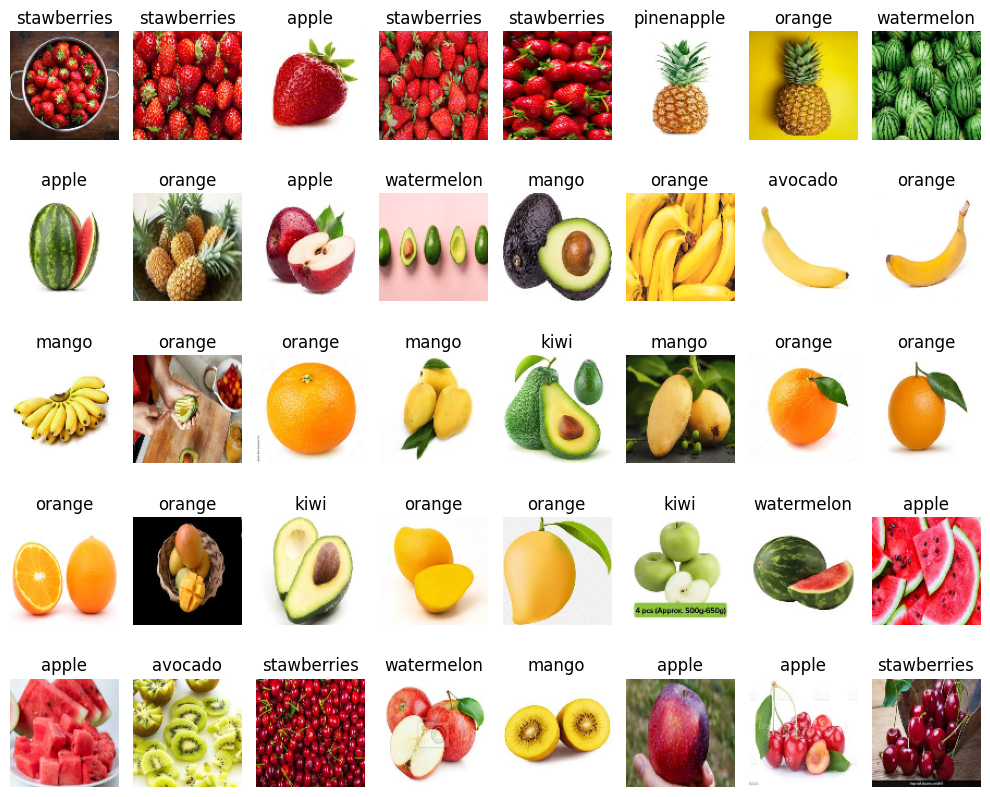

['stawberries' 'stawberries' 'apple' 'stawberries' 'stawberries'
 'pinenapple' 'orange' 'watermelon' 'apple' 'orange' 'apple' 'watermelon'
 'mango' 'orange' 'avocado' 'orange' 'mango' 'orange' 'orange' 'mango'
 'kiwi' 'mango' 'orange' 'orange' 'orange' 'orange' 'kiwi' 'orange'
 'orange' 'kiwi' 'watermelon' 'apple' 'apple' 'avocado' 'stawberries'
 'watermelon' 'mango' 'apple' 'apple' 'stawberries' 'cherry' 'apple'
 'pinenapple' 'kiwi' 'watermelon' 'orange' 'pinenapple' 'mango']


In [9]:
import matplotlib.pyplot as plt
import numpy as np

# Prediction
predict_images, _ = load_images_from_folder('data/predict/')  # Load predict images
predictions = model.predict(predict_images)

# Get the predicted class for each image
predicted_labels = np.argmax(predictions, axis=1)
predicted_fruits = label_encoder.inverse_transform(predicted_labels)

# Plot each image with its predicted fruit label
plt.figure(figsize=(10, 10)) 

for i in range(40):
    plt.subplot(6, 8, i + 1) 
    img_rgb = cv2.cvtColor(predict_images[i], cv2.COLOR_BGR2RGB)
    plt.imshow(img_rgb) 
    plt.title(predicted_fruits[i])  
    plt.axis('off')  # Hide the axes to make it cleaner

plt.tight_layout()
plt.show() 

print(predicted_fruits)  # Show the predicted fruits


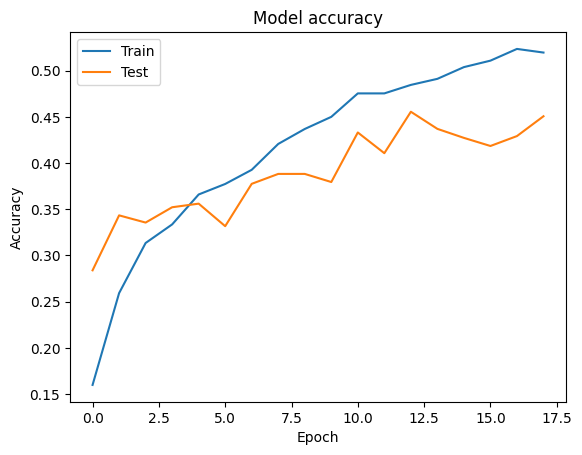

In [10]:
# visualizing
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


In [11]:
# saving the model
model.save('fruit_classification_model.h5')


c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
